In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,recall_score, precision_score,f1_score
from imblearn.over_sampling import SMOTE

# Load the dataset


In [2]:
df = pd.read_csv("./data/credit_card_transactions.csv")
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


##  downsample dataset to 100,000 rows while preserving the original ratio of fraudulent vs non-fraudulent transactions.


In [3]:
# Define desired number of rows
n_rows = 100000

# Use stratified sampling
df = df.groupby("is_fraud", group_keys=False).apply(
    lambda x: x.sample(frac=n_rows / len(df), random_state=42)
)

# Check the new shape
print(df.shape)
# Check the ratio of fraud vs non-fraud
print(df["is_fraud"].value_counts(normalize=True))

(100000, 24)
is_fraud
0    0.99421
1    0.00579
Name: proportion, dtype: float64


C:\Users\Asus\AppData\Local\Temp\ipykernel_23268\557766383.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("is_fraud", group_keys=False).apply(


In [4]:
df.value_counts()

Unnamed: 0  trans_date_trans_time  cc_num               merchant                           category       amt     first        last        gender  street                          city                      state  zip    lat      long       city_pop  job                                       dob         trans_num                         unix_time   merch_lat  merch_long   is_fraud  merch_zipcode
23          2019-01-01 00:17:40    630441765090         fraud_Pacocha-Bauch                shopping_pos   9.55    Susan        Washington  F       759 Erin Mount Suite 956        May                       TX     76857  31.9571  -98.9656   1791      Corporate investment banker               1965-07-26  c4b4daebab8be54cadde4b941244ca53  1325377060  31.626350  -98.610225   0         76870.0          1
31          2019-01-01 00:22:39    4599735407877245080  fraud_Heller, Gutmann and Zieme    grocery_pos    82.80   Mary         Myers       F       39787 Pamela Fall Suite 639     Tiptonville           

# remove columns 'Unnamed: 0'

In [5]:
df = df.drop(columns=["Unnamed: 0"])
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
811778,2019-12-07 10:55:06,676173792455,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,Brittany,Cox,F,07177 William Dale Apt. 547,Santa Monica,...,-118.4924,92043,"Civil engineer, contracting",1961-04-25,f32d1f4b2a918f4c2f6acdc83033ee35,1354877706,33.287851,-118.740970,0,NaN
1101718,2020-04-03 13:10:06,30518206766474,fraud_Lind-Buckridge,entertainment,85.81,Tamara,Martinez,F,471 Marquez Prairie Suite 680,Matthews,...,-89.6287,1019,Aeronautical engineer,1979-01-26,f5dad8e2d7c39d81502d846a20286659,1364994606,36.539950,-89.857416,0,63870.0
800013,2019-12-04 07:07:04,4658490815480264,fraud_Hackett-Lueilwitz,grocery_pos,99.30,Tara,Richards,F,4879 Cristina Station,Keisterville,...,-79.7853,184,Systems developer,1945-11-04,1d023bc78ab93ab65a35bbb53bcc67bd,1354604824,39.582872,-78.838550,0,21557.0
398945,2019-06-30 18:43:08,4716561796955522,fraud_Lynch-Wisozk,home,42.09,Lauren,Anderson,F,11014 Chad Lake Apt. 573,Heart Butte,...,-112.8456,743,Water engineer,1972-05-04,dbf6c06d3277438afdf7af883fb4285f,1341081788,48.310513,-112.837535,0,NaN
207455,2019-04-15 19:57:49,3528407217576457,fraud_Fisher-Schowalter,shopping_net,4.24,Patricia,Leach,F,71309 Martinez Stravenue,Kingsport,...,-82.4834,87124,Warden/ranger,1987-02-14,88814660aba0101b174e1e8137f4a7af,1334519869,37.329094,-82.070746,0,24614.0


In [6]:
# dissplay summary statistics
print(df.describe())

             cc_num            amt            zip            lat  \
count  1.000000e+05  100000.000000  100000.000000  100000.000000   
mean   4.214353e+17      69.825856   48780.682330      38.567738   
std    1.314526e+18     150.256459   26937.717614       5.070358   
min    6.041621e+10       1.000000    1257.000000      20.027100   
25%    1.800365e+14       9.660000   26041.000000      34.668900   
50%    3.520550e+15      47.410000   48174.000000      39.401500   
75%    4.651007e+15      82.600000   72042.000000      41.948800   
max    4.992346e+18   13536.840000   99783.000000      66.693300   

                long      city_pop     unix_time      merch_lat  \
count  100000.000000  1.000000e+05  1.000000e+05  100000.000000   
mean      -90.258384  8.789937e+04  1.349275e+09      38.568450   
std        13.787629  2.976825e+05  1.280539e+07       5.101745   
min      -165.672300  2.300000e+01  1.325376e+09      19.033288   
25%       -96.809400  7.430000e+02  1.338900e+09    

In [7]:
# checking missing values
print(df.isnull().sum())

trans_date_trans_time        0
cc_num                       0
merchant                     0
category                     0
amt                          0
first                        0
last                         0
gender                       0
street                       0
city                         0
state                        0
zip                          0
lat                          0
long                         0
city_pop                     0
job                          0
dob                          0
trans_num                    0
unix_time                    0
merch_lat                    0
merch_long                   0
is_fraud                     0
merch_zipcode            15110
dtype: int64


In [8]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'merch_zipcode'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 811778 to 154913
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  100000 non-null  object 
 1   cc_num                 100000 non-null  int64  
 2   merchant               100000 non-null  object 
 3   category               100000 non-null  object 
 4   amt                    100000 non-null  float64
 5   first                  100000 non-null  object 
 6   last                   100000 non-null  object 
 7   gender                 100000 non-null  object 
 8   street                 100000 non-null  object 
 9   city                   100000 non-null  object 
 10  state                  100000 non-null  object 
 11  zip                    100000 non-null  int64  
 12  lat                    100000 non-null  float64
 13  long                   100000 non-null  float64
 14  city_pop               100000 non-nu

In [10]:
# Drop non-predictive columns
df = df.drop(
    ["cc_num", "trans_num", "first", "last", "street", "dob", "unix_time", "job"], axis=1)

In [11]:
df.head()

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,merch_zipcode
811778,2019-12-07 10:55:06,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,F,Santa Monica,CA,90403,34.0287,-118.4924,92043,33.287851,-118.740970,0,NaN
1101718,2020-04-03 13:10:06,fraud_Lind-Buckridge,entertainment,85.81,F,Matthews,MO,63867,36.7154,-89.6287,1019,36.539950,-89.857416,0,63870.0
800013,2019-12-04 07:07:04,fraud_Hackett-Lueilwitz,grocery_pos,99.30,F,Keisterville,PA,15449,39.9636,-79.7853,184,39.582872,-78.838550,0,21557.0
398945,2019-06-30 18:43:08,fraud_Lynch-Wisozk,home,42.09,F,Heart Butte,MT,59448,48.2777,-112.8456,743,48.310513,-112.837535,0,NaN
207455,2019-04-15 19:57:49,fraud_Fisher-Schowalter,shopping_net,4.24,F,Kingsport,TN,37663,36.4715,-82.4834,87124,37.329094,-82.070746,0,24614.0


In [12]:
# Handle missing values
df["merch_zipcode"] = df["merch_zipcode"].fillna(-1)  # Using -1 as a placeholder for missing values

# Feature Engineering

In [13]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["trans_hour"] = df["trans_date_trans_time"].dt.hour
df["trans_dayofweek"] = df["trans_date_trans_time"].dt.dayofweek  # starting as monday=0
df["trans_month"] = df["trans_date_trans_time"].dt.month
df["trans_is_weekend"] = df["trans_dayofweek"].isin([5, 6]).astype(int)
df = df.drop("trans_date_trans_time", axis=1)

In [14]:
# List of categorical columns to encode
categorical_cols = [
    "merchant",
    "category",
    "gender",
    "city",
    "state",
    "zip",
    "merch_zipcode",
]

# Use LabelEncoder to transform categorical columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [15]:
df

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,merch_zipcode,trans_hour,trans_dayofweek,trans_month,trans_is_weekend
811778,691,2,86.19,0,706,4,865,34.0287,-118.4924,92043,33.287851,-118.740970,0,0,10,5,12,1
1101718,390,0,85.81,0,471,24,637,36.7154,-89.6287,1019,36.539950,-89.857416,0,15895,13,4,4,0
800013,217,4,99.30,0,387,38,128,39.9636,-79.7853,184,39.582872,-78.838550,0,4559,7,2,12,0
398945,402,6,42.09,0,325,26,589,48.2777,-112.8456,743,48.310513,-112.837535,0,0,18,6,6,1
207455,175,11,4.24,0,396,42,359,36.4715,-82.4834,87124,37.329094,-82.070746,0,5308,19,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144910,245,8,885.76,0,404,42,363,35.9335,-84.1481,391389,35.749032,-84.117199,1,8602,3,1,3,0
15454,392,11,937.57,0,460,45,207,37.7184,-77.1860,976,38.193305,-77.665911,1,4767,22,2,1,0
209208,105,11,1094.57,1,632,9,320,26.9379,-82.2388,79008,26.073774,-81.254368,1,0,19,1,4,0
71759,256,11,853.80,1,17,50,823,44.6873,-104.4414,110,44.062324,-103.879906,1,0,22,0,2,0


In [16]:
# Separate features and target
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:

X

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,merch_lat,merch_long,merch_zipcode,trans_hour,trans_dayofweek,trans_month,trans_is_weekend
811778,691,2,86.19,0,706,4,865,34.0287,-118.4924,92043,33.287851,-118.740970,0,10,5,12,1
1101718,390,0,85.81,0,471,24,637,36.7154,-89.6287,1019,36.539950,-89.857416,15895,13,4,4,0
800013,217,4,99.30,0,387,38,128,39.9636,-79.7853,184,39.582872,-78.838550,4559,7,2,12,0
398945,402,6,42.09,0,325,26,589,48.2777,-112.8456,743,48.310513,-112.837535,0,18,6,6,1
207455,175,11,4.24,0,396,42,359,36.4715,-82.4834,87124,37.329094,-82.070746,5308,19,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144910,245,8,885.76,0,404,42,363,35.9335,-84.1481,391389,35.749032,-84.117199,8602,3,1,3,0
15454,392,11,937.57,0,460,45,207,37.7184,-77.1860,976,38.193305,-77.665911,4767,22,2,1,0
209208,105,11,1094.57,1,632,9,320,26.9379,-82.2388,79008,26.073774,-81.254368,0,19,1,4,0
71759,256,11,853.80,1,17,50,823,44.6873,-104.4414,110,44.062324,-103.879906,0,22,0,2,0


In [18]:
y

811778     0
1101718    0
800013     0
398945     0
207455     0
          ..
144910     1
15454      1
209208     1
71759      1
154913     1
Name: is_fraud, Length: 100000, dtype: int64

In [20]:
len(X_train),len(X_test),len(y_train),len(y_test)

(80000, 20000, 80000, 20000)

# Model Training and MLflow Tracking

In [46]:
# Set up MLflow
mlflow.set_experiment("Credit Card Fraud Detection with RandomForest, XGBoost, LGBM")

def train_and_log_model(model, model_name, X_train, y_train, X_test, y_test, is_lgbm=False, cat_features=[]):
    """
    trains a model using SMOTE, evaluates it, and logs the results to MLflow.
    Special handling for LightGBM's categorical features.
    """
    with mlflow.start_run(run_name=model_name):
        #log model parameters
        mlflow.log_params(model.get_params())

        #apply SMOTE to the training data
        smote = SMOTE(random_state=42)
        print(f"Applying SMOTE for {model_name}...")
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        print(f'length of X_train_resampled: {len(X_train_resampled)}, length of y_train_resampled: {len(y_train_resampled)}')

        #train the model
        print(f"Training {model_name}...")
        if is_lgbm:
            model.fit(X_train_resampled, y_train_resampled, categorical_feature=cat_features)
        else:
            model.fit(X_train_resampled, y_train_resampled)

        #make predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        #calculate metrics
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        #log metrics to MLflow
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)
        
        #log the trained model as an artifact
        mlflow.sklearn.log_model(model, "model")

        print(f"--- {model_name} Results ---")
        print(f"Recall: {recall:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
        print("-" * 20)

#plotting the top 10 feature importance for each model
def plot_feature_importance(model, feature_names, model_name, top_n=10):
    importance = model.feature_importances_
    fi_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(fi_df["Feature"][:top_n][::-1], fi_df["Importance"][:top_n][::-1])
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"{model_name} Feature Importance (Top {top_n})")
    plt.show()
    
    


starting Random Forest training..
Applying SMOTE for Random Forest...
length of X_train_resampled: 159074, length of y_train_resampled: 159074
Training Random Forest...


2025/09/26 09:39:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/26 09:39:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- Random Forest Results ---
Recall: 0.5948
Precision: 0.4452
F1-Score: 0.5092
ROC-AUC: 0.9656
--------------------


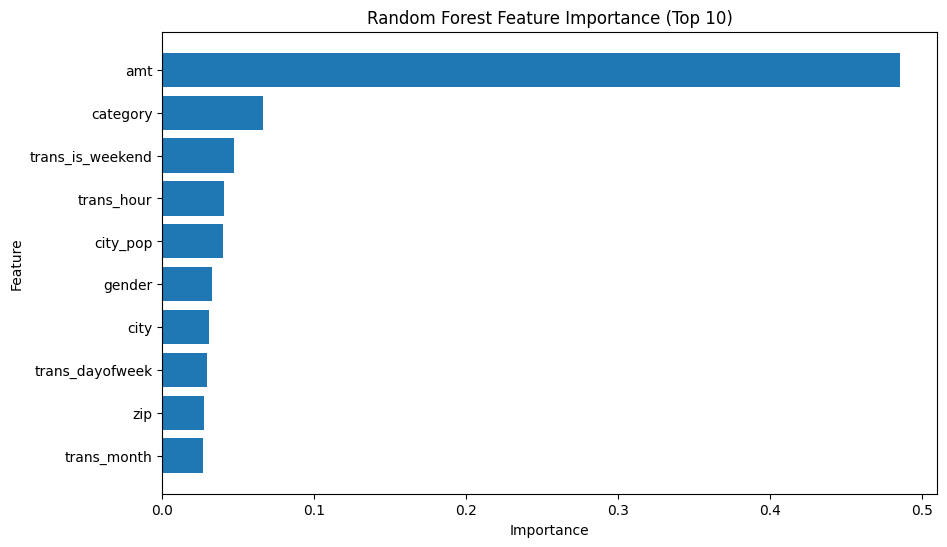

starting XGBoost training..
Applying SMOTE for XGBoost...
length of X_train_resampled: 159074, length of y_train_resampled: 159074
Training XGBoost...


2025/09/26 09:39:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/26 09:39:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- XGBoost Results ---
Recall: 0.7328
Precision: 0.4830
F1-Score: 0.5822
ROC-AUC: 0.9568
--------------------


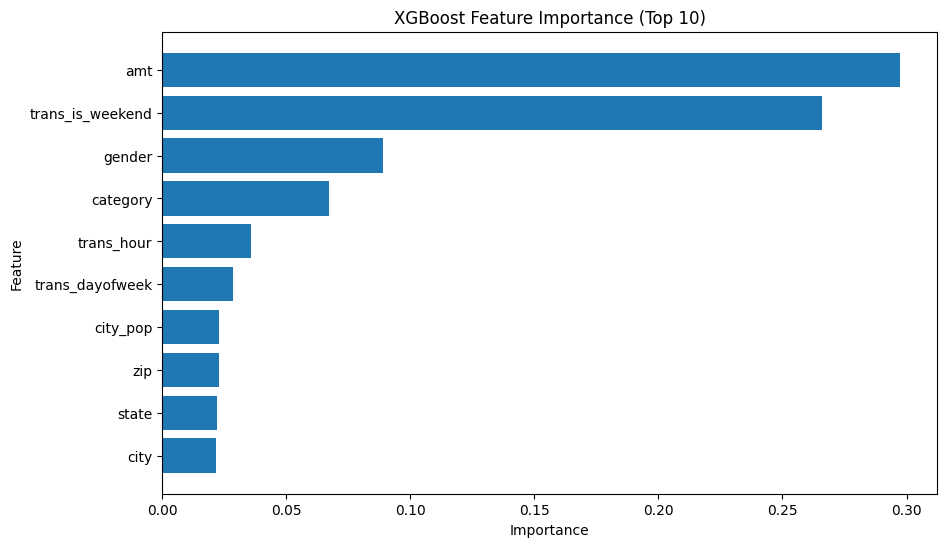

starting LightGBM training..
Applying SMOTE for LightGBM...
length of X_train_resampled: 159074, length of y_train_resampled: 159074
Training LightGBM...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 79537, number of negative: 79537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23851
[LightGBM] [Info] Number of data points in the train set: 159074, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2025/09/26 09:39:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/26 09:39:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Asus\AppData\Local\Temp\tmp6w834w2m\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.7.2', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/09/26 09:39:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--- LightGBM Results ---
Recall: 0.7931
Precision: 0.5027
F1-Score: 0.6154
ROC-AUC: 0.9854
--------------------


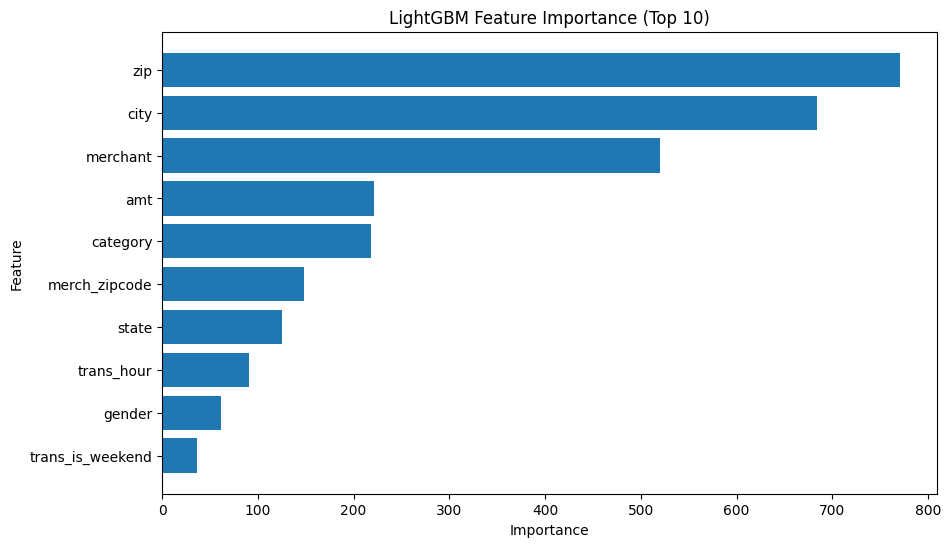

In [47]:

#initialize and run models
print("starting Random Forest training..")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
train_and_log_model(rf_model, "Random Forest", X_train, y_train, X_test, y_test)
plot_feature_importance(rf_model, X_train.columns, "Random Forest")

print("starting XGBoost training..")
xgb_model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42, n_jobs=-1)
train_and_log_model(xgb_model, "XGBoost", X_train, y_train, X_test, y_test)
plot_feature_importance(xgb_model, X_train.columns, "XGBoost")

print("starting LightGBM training..")
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1)
train_and_log_model(lgbm_model, "LightGBM", X_train, y_train, X_test, y_test, is_lgbm=True, cat_features=categorical_cols)
plot_feature_importance(lgbm_model, X_train.columns, "LightGBM")

In [30]:
print(lgbm_model.feature_importances_)

[520 218 221  61 684 125 771  13  12  15   3  15 148  91  32  35  36]


In [33]:
df1 = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": lgbm_model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

In [34]:
df1

,Feature,Importance
6,zip,771
4,city,684
0,merchant,520
2,amt,221
1,category,218
12,merch_zipcode,148
5,state,125
13,trans_hour,91
3,gender,61
16,trans_is_weekend,36


In [43]:
(df1["Feature"])[:10]

6                  zip
4                 city
0             merchant
2                  amt
1             category
12       merch_zipcode
5                state
13          trans_hour
3               gender
16    trans_is_weekend
Name: Feature, dtype: object

In [ ]:

plt.barh(df1["Feature"][:top_n][::-1], fi_df["Importance"][:top_n][::-1])